# Digital Signal Processing for Speech, Language, & Hearing Sciences 
# Tutorial 4: Fourier Transforms

**Meg Cychosz**, *University of Maryland-College Park & UCLA*

## Table of Contents
1. [Introduction](#intro)
2. [Defining the DFT](#defining)
3. [Plotting the output function](#plotting)
4. [Inverse discrete Fourier transform](#inverse)
5. [Harmonics](#harmonics)
6. [Leakage](#leakage)
7. [Fast Fourier Transform](#fft)
8. [Sampling and the Fast Fourier Transform](#sampling)

In [2]:
import os, re
import time
import numpy as np
import librosa as lb
from librosa import display
import scipy as sc
from scipy import signal
from scipy.fft import fft, fftfreq, rfft, rfftfreq
import matplotlib.pyplot as plt
import matplotlib.patches as matpat
import IPython.display as ipd
import warnings
warnings.filterwarnings('ignore')
path = os.getcwd()

## 1. Introduction<a name="intro"></a> 

In speech and hearing sciences, there are three dimensions that we work in to help us characterize the shape and movement of sounds: time, intensity, and frequency. When we have a simple sine wave function, like the plot below, it's straightforward to compute both time (x-axis), intensity (y-axis), and frequency (number of oscillations per second). 

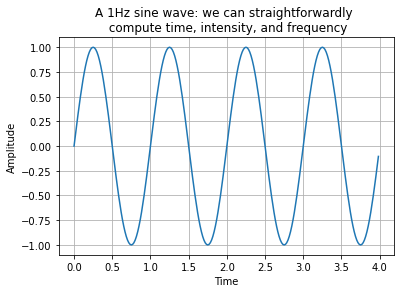

In [2]:
sr = 60
t = np.arange(0, 4, (1/sr)) 
a = np.sin(t*(2*np.pi)) 

plt.figure()
plt.grid(True, which='both')
plt.plot(t, a)
plt.ylabel('Amplitude')
plt.xlabel('Time')
plt.title("A 1Hz sine wave: we can straightforwardly \n compute time, intensity, and frequency")
plt.show()

However, most signals in the real world are more interesting than sine waves. Many signals are **complex**, often meaning that they are composed of multiple sine (and cosine) waves added together, like the plots below illustrate. The yellow and red sine waves can be added together to generate the complex, sinusoidal function in orange. 

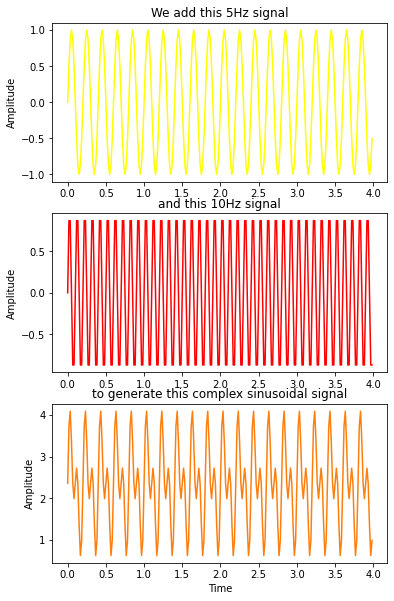

In [3]:
# generate a complex sinusoidal function
t = np.arange(0, 4, (1/sr))
f = np.sin(2*np.pi*5*t) 
te = np.sin(2*np.pi*10*t) 
sinu = f + (te+(3*np.pi/4)) # offset the phase 

# visualize it
fig, axs = plt.subplots(3)
axs[0].plot(t,f,'yellow')
axs[0].set_title('We add this 5Hz signal')
axs[1].plot(t,te,'red')
axs[1].set_title('and this 10Hz signal')
axs[2].plot(t,sinu,'tab:orange')
axs[2].set_title('to generate this complex sinusoidal signal')
plt.ylabel('Amplitude')
plt.xlabel('Time')
plt.subplots_adjust(top=2)

for ax in axs.flat:
    ax.set(ylabel='Amplitude')

The essence behind Fourier transforms is that we want to change a continuous time by intensity function (our traditional waveform) into a frequency by intensity function (the **spectrum** or spectral envelope). We accomplish this by teasing apart the individual sine waves that make up the complex function. That is, in the plots above, we "unmix" the orange color giving us 1 simple yellow sine wave and 1 red.  We can then straightforwardly compute the frequency of each simple sine wave and plot the relationship between frequency and amplitude in a spectrum. 

Thus, Fourier transforms allow us to take a 1-dimensional array of amplitude measures (given that we know the sampling rate) and derive a function representing the relationship between frequency (also known as harmonic) information and amplitude in the signal. 

There are two broad types of Fourier transforms that will be discussed in this tutorial: the **discrete Fourier transform** (DFT) and the **fast Fourier transform** (FFT). The fast Fourier transform is, well, faster than the discrete. And while there are innumerable ready-made functions in most computing environments to derive both of these Fourier transforms (many of which are used throughout this notebook), it helps to understand the math under the hood so that we can explore more complex topics. For one thing, understanding how to derive a DFT from scratch will help us understand why the FFT is faster and thus often preferable!

## 2. Defining the DFT<a name="defining"></a> 

There are a couple of (equivalent) ways that we can express the DFT mathematically. Most traditionally, the DFT is expressed exponentially:

    for n in x:
        output_seq = np.dot(x, np.exp(-2j*np.pi*m*n / N))

* where x is the input time-domain signal sequence
* N is the number of elements in the time-domain signal sequence *and* the number of elements in the DFT output sequence (frequency-domain signal sequence)
* m is the index (#) of the DFT output in the frequency-domain signal
* n is the index (#) of the input time-domain signal 
* and j = np.sqrt(-1)

But that equation looks gnarly so we can also express the DFT (again, equivalently) trigonometrically:

    for n in x:
        output_seq = np.dot(x, np.cos((2*np.pi*n*m)/N) - j*np.sin((2*np.pi*n*m)/N))
        
So the DFT is just the product of a complex waveform `(cos - j*sin)` and the original signal value.

Let's define functions for each of these DFT options to re-use throughout the tutorial. 

In [5]:
# the exponential function
def dft(signal):

    N = len(signal)
    n = np.arange(0,N) # get values from 0 to len(N)
    m = n.reshape((N, 1)) # change from horizontal to vertical
    out = np.dot(signal, np.exp(-2j*np.pi*m*n / N)) # dot product of the two arrays
    
    return out

In [54]:
# the trigonometric function
def dft_trig(signal):

    N = len(signal)
    n = np.arange(0,N)
    m = n.reshape((N, 1)) 
    out = np.dot(signal, np.cos((2*np.pi*n*m)/N) - 2j*np.sin((np.pi*n*m)/N)) 
    
    return out

In [55]:
# compare run times of the exponential and trig functions
sr = 16000
t_short = np.arange(0.05, 1, (1/sr)) 
a_short = np.sin(t_short*(2*np.pi)) 
now = time.process_time()

out = dft(a_short)
print('Exponential DFT takes', np.round(time.process_time() - now,2), 'seconds')

Exponential DFT takes 21.42 seconds


In [56]:
now = time.process_time()
out2 = dft_trig(a_short)
print('and trigonometric DFT takes', np.round(time.process_time(),2) - now, 'seconds')

and trigonometric DFT takes 25.346013 seconds


We'll call `dft()` for the remainder of this notebook.

## 3. Plotting the output function<a name="plotting"></a> 

Now that we have the DFT output, we are almost ready to plot our spectral function (the relationship between signal amplitude and frequency). However, before doing so, it may help to ask: what *is* the output array from the DFT? For example, does it tell us the frequencies contained within the signal? 

No. The DFT output merely gives us an array containing information about the spectral content of the signal at *N equally spaced points.* That "spectral content" indicates the magnitude and phase at each frequency of the input signal. But the DFT output does not tell us at which frequencies those magnitudes and phases occur. To compute the exact frequency of each of our DFT output components, we have to know the sampling rate:

    dft_frequency = (m*sr)/N

* where m is the output array number
* sr is the original sampling rate
* and N is the number of input samples

So for a 50-sample signal, sampled at 1000 samples/second, we could theoretically expect to be able to measure the magnitudes of the signal at the following frequencies in the output:

    (1*1000)/50 = 20 Hz
    (2*1000)/50 = 40 Hz
    (3*1000)/50 = 60 Hz
    ...
    (49*1000)/50 = 980 Hz

So each frequency is an integer multiple of the **fundamental frequency** or 

    f0 = sr/N

* where sr is the original sampling rate
* and N is the number of input samples

So N is super important because it indicates the number of input samples that we have, but it also determines the *resolution* and steps of the output frequency scale. 

### Some other aspects of the frequency domain array

There are a couple of other aspects to recall about the frequency domain array. 

Recall that we must specify a sampling rate at least two times greater than the highest frequency component (we wish to capture) in the signal (**Nyquist frequency**). Attempting to identify frequencies up to, for example, 15kHz in a signal sampled at 28kHz will result in **aliasing**, or when we specify the incorrect sampling rate and our reconstructed signal ends up containing different frequencies from the original. We explored this topic in more detail in the introductory tutorial. 

To avoid aliasing, we can take several steps. For one thing, before recording, we can identify the highest frequency component that we anticipate needing to identify in our signal, and we can make sure to employ a sampling rate at *at least* twice as large. For example, in adult speech analysis, we're unlikely to be interested in frequencies above 8kHz, so sampling at 22kHz is sufficient (and our field standard of 44.1kHz is certainly enough!).

Another step that we can take is to apply one or more **anti-aliasing filters** during signal processing. One common example is filtering all freqencies below the Nyquist frequency. Sometimes these anti-aliasing filters are built into the analog to digital conversion pipeline, in a computer's sound card, for example. We did not include this anti-aliasing filter in our `dft()` function, so we'll have to apply it when we plot the frequency domain data later in this tutorial. 

Another point to remember is that the first element in the frequency domain array is always 0. In other words, the mean amplitude should always be 0 unless the signal has an amplitude bias (DC bias) in the negative or positive direction. If the signal is biased in this way, there are straightforward normalization procedures that one could apply to the frequency domain array, such as computing the average amplitude over all samples and dividing each amplitude measure by this amount. 

So, with this new-found understanding of what DFT output is and is not, let's apply the DFT and then compute the frequencies within the signal to plot the spectrum. 

### Side note: Why is it called "DC bias"?

**DC bias**, or or direct current bias, refers to when the average amplitude of a signal is not 0. In this case, we often say that a signal is riding a DC bias because the signal is *shifted* in ampltiude, negatively or positively. To understand DC bias, it may help to contrast direct currents from alternating currents (see plots helow). Being able to define (and draw) AC and DC could also be a cool party trick you can share next time this [song](https://www.youtube.com/watch?v=pAgnJDJN4VA) plays.  

DC bias can have many sources: it could have been present in the original analog signal, it could stem from imperfect analog-to-digital conversion via your computer's sound card, etc. However, as previously stated, DC bias is straightforwardly removed by taking the moving average of all the amplitude measures and subtracting it from each one. 

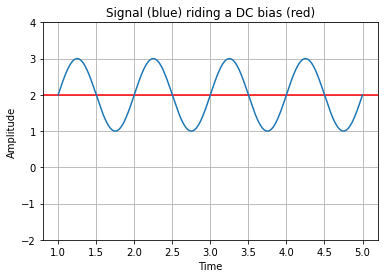

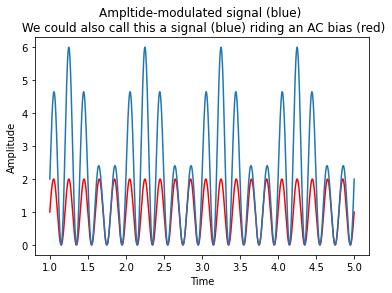

In [14]:
sr = 20050
t = np.arange(1, 5, (1/sr)) 
a = np.sin(t*(2*np.pi)*1) + 2

plt.figure()
plt.grid(True, which='both')
plt.axhline(y=2, color='red') # DC bias
plt.plot(t, a)
ax = plt.gca()
ax.set_ylim([-2, 4])
plt.ylabel('Amplitude')
plt.xlabel('Time')
plt.title('Signal (blue) riding a DC bias (red)')
plt.show()

ac = np.sin(t*(2*np.pi)*5) + 1

plt.figure()
plt.plot(t,ac,c="red")
plt.plot(t,np.multiply(ac,a))
plt.ylabel('Amplitude')
plt.xlabel('Time')
plt.title("Ampltide-modulated signal (blue) \n We could also call this a signal (blue) riding an AC bias (red)")
plt.show()

In [6]:
# apply the dft to transform signal to the frequency domain
spec = dft(sinu)

# identify the frequencies within the signal up to Nyquist for the spectra
# this is our anti-aliasing filter
sr = 60
N = len(spec)
nyq = N//2
freq_sinu = ((np.arange(N)*sr)/N)[:nyq]
amp_sinu = spec[:nyq]/nyq

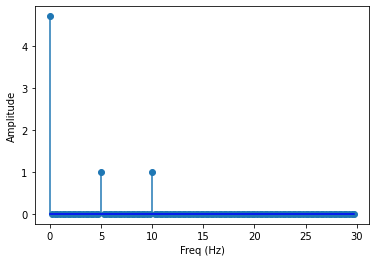

In [58]:
plt.figure()
plt.stem(freq_sinu, abs(amp_sinu), basefmt="-b")
plt.xlabel('Freq (kHz)')
plt.ylabel('Amplitude')
plt.show()

We tend to plot spectra in two domains: magnitude/amplitude spectra and power spectra (dft/fft `magnitude**2`). So you may alternatively see the relationship between frequency and amplitude expressed in a power spectrum like this:

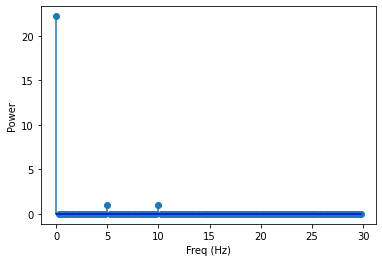

In [7]:
# visualize power spectrum
plt.figure()
plt.stem(freq_sinu, abs(amp_sinu)**2,basefmt="-b")
plt.xlabel('Freq (Hz)')
plt.ylabel('Power')
plt.show()

### An alternative 

Sometimes you may instead see the DFT equation written with a scalar like this:

    output_component = (1/N)*np.cos((2*np.pi*n*m)/N) - j*np.sin((2*np.pi*n*m)/N)

This equation has us scaling the DFT output frequency domain array by the number of input samples (N). The output magnitude of a sinewave signal, with a frequency less than half the sampling rate, can be expressed as:

    output = A*(N/2)

where A is the input amplitude maxima and N is the number of samples in the input array. 

So, we may choose to scale our output, by dividing by the number of input samples, if we were concerned that our system would be unable to hold N/2 times the amplitude maxima in memory. 

## 4. Inverse discrete Fourier transform<a name="inverse"></a> 

We can reverse the results of any discrete Fourier transform; that is, we can convert a frequency domain signal into a time domain signal by slightly modifying our original mathematical expression:    
    
    for n in output:
        input_component = np.dot(x, (1/N)*np.exp(2j*np.pi*m*n / N))

* where x is the input time-domain signal sequence
* N is the number of elements in the time-domain signal sequence *and* the number of elements in the DFT output sequence (frequency-domain signal sequence)
* m is the index (#) of the DFT output in the frequency-domain signal
* n is the index (#) of the input time-domain signal 
* and j = np.sqrt(-1)

But that equation looks gnarly so we can also express the inverse DFT (again, equivalently) trigonometrically:

    for n in output:
        input_component = np.dot(x, (1/N)*np.cos((2*np.pi*n*m)/N) + j*np.sin((2*np.pi*n*m) / N))

So, we simply scale by N (the number of elements in the output array) and change the polarity of the sine wave component from negative to positive (compare this equation to the original trigonometric DFT). In doing so, we can derive a time domain signal from the frequency domain and "undo" the results of the DFT. 

## 5. Harmonics<a name="harmonics"></a> 

At this point, it may be worth remembering why speech and hearing scientists are even interested in Fourier transforms! What are the components of a frequency or power spectrum and why do we care to measure them?

The power spectrum visualizes the amplitude of various frequencies in a complex signal. In speech, the complex signal we're usually referring to is the voice and the frequencies are the **harmonics**, the most basic of which is the fundamental frequency, or first harmonic. 

We've already established that the fundamental frequency, or f0, is the number of times that a periodic function repeats per second and that it can be computed as follows:

    f0 = sr/N

* where sr is the sampling rate
* and N is the number of samples

f0 is also related to the perceived pitch of a speaker's voice.

First, let's read in an audio file which we'll use to better understand f0 and its harmonics. This is a recording of [a] synthesized from a five-year-old's vocal tract:

In [8]:
sr = 44100
sound_file, sr = lb.load(path+'/files/Vowel_Child_aa.wav',sr=sr)

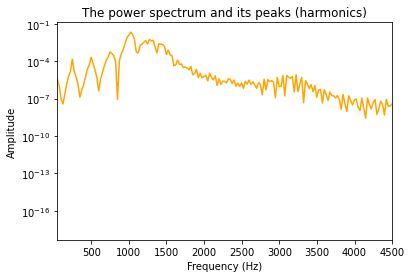

In [9]:
(freq, spec) = sc.signal.periodogram(sound_file, sr, scaling="spectrum") # power spectrum, alternatively "density" can be specified for power spectral density
#(freq, psd) = sc.signal.welch(sound_file, sr, nperseg=2048) # Welch's is better for heavier signals

plt.semilogy(freq, spec,"orange") 
plt.ylabel('Amplitude') # or Power spectral density (dB/Hz), depending on the parameter you specified above
plt.xlabel('Frequency (Hz)')
plt.xlim(50,4500)
plt.title("The power spectrum and its peaks (harmonics)")
plt.show()

Each frequency "peak" represented in the power spectrum is a harmonic. Even though this is synthesized speech, the harmonics aren't perfectly represented: the highest amplitude peak is often f0, but that is not the case for this vowel. And in fact child speech introduces some problems for traditional spectral representations that we'll discuss in later tutorials. But the first peak in the spectrum is indeed at or around 225Hz, which corresponds approximately to this child's f0. Subsequent peaks are integer multiples of this f0: 450, 675, 900, etc. 

So Fourier transforms are useful for speech scientists because they allow us to characterize and quantify the individual harmonic components of the speech signal such as the ratio between different harmonics' amplitudes (corresponding to voice quality) as well as characteristics of the spectral envelope, such as its overall tilt or amplitude relative to another speech sound. 

## 6. Leakage<a name="leakage"></a>  

Now that we've established how to perform a DFT – what our input time domain array and output frequency domain array contain - it's worth considering more complex signals than simple combinations of sinusoidal functions. 

Currently, our DFT assumes a complex signal made up of frequencies that are exact integer multiples of the sampling rate divided by the number of input samples (the fundamental frequency). But this is not realistic. In reality, we may have a signal with energy concentrated at frequencies *between* the integer multiples. In this case, **leakage** between elements of our output array may occur: the energy present in the signal outside of our integer multiples would be dispersed throughout adjacent frequency samples (also known as frequency **bins**). For example, in our previous example, we computed the frequencies in the output array for a 50-sample signal, sampled at 1000 samples/second:

    (0*1000)/50 = 0 Hz
    (1*1000)/50 = 20 Hz
    (2*1000)/50 = 40 Hz
    (3*1000)/50 = 60 Hz
    ...
    (49*1000)/50 = 980 Hz

So for a 1000 Hz, 50-point DFT, leakage would occur for *any* signal at non-integer multiples of the fundamental frequency (e.g. 1, 2, 3, 21, 22, Hz). Let's explore this further with an example.

DFT leakage is a problem because we could be fooled into thinking that there is energy in our signal at certain frequencies where there is not. Furthermore, DFT leakage manifests in **sidelobes**, which just reflect the magnitude of the adjacent non-integer multiple frequency bins (they are called lobes because they are often plotted as a continuous spectral function although of course the DFT output is composed of discrete measurements).

Thus, besides falsely manifesting energy at certain frequencies, leakage is also a problem because the adjacent sidelobes might hide any low-magnitude signals that are close to the main lobe's frequency bin or fall in the sidelobes' path. 

### Windows 

One way to contend with the leakage problem discussed above is through the use of **window functions**, also called windowing. Essentially, we want to select only a subset of all the time domain input values, i.e. we apply a window so that only *some* of those values are passed to the DFT. 

Now, not all window functions are created equal. A relatively simple window function is a rectangular or uniform window. Time domain values *inside* the window function are passed to the DFT and values *outside* are not. To accomplish this rectangular window effect, we simply multiply the time domain input array by an array of equivalent length consisting of 1s (corresponding to the input amplitude values we would like to pass to the DFT) and 0s (corresponding to the input amplitude values that we would like to cancel out to 0). A rectangular window function is illustrated in the following plots:

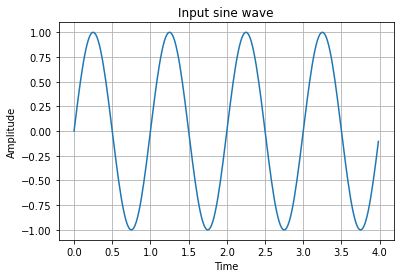

In [10]:
a = np.sin(t*(2*np.pi)) 

plt.figure()
plt.grid(True, which='both')
plt.plot(t, a)
plt.ylabel('Amplitude')
plt.xlabel('Time')
plt.title("Input sine wave")
plt.show()

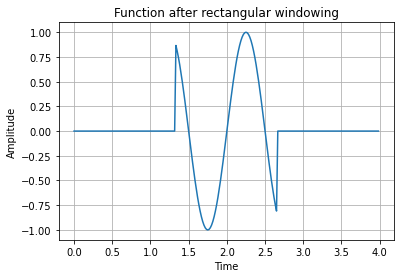

In [11]:
# an array of equivalent length with 0s and 1s
rec_win = np.concatenate([([0] * int(len(a)/3)),([1] * int(len(a)/3)),([0] * int(len(a)/3))]) 

plt.figure()
plt.grid(True, which='both')
plt.plot(t, a*rec_win) # multiple the arrays together 
plt.ylabel('Amplitude')
plt.xlabel('Time')
plt.title("Function after rectangular windowing")
plt.show()

Still, if a goal of windowing is to reduce spectral leakage, rectangular window functions are less-than-ideal. In fact, the very coarse nature of the 0s and 1s in the rectangular window function array may *cause* some of the spectral leakage that we are trying to avoid! Consequently, the focus of windowing is not necessarily to select which time domain values are passed to the DFT and which are reduced to 0. Instead, windowing is all about finding an appropriate function to gently *transition* between those input values that are kept, and those that are cancelled. 

Two of the most common of these *gentle* windows are the Hanning window and the Hamming window, visualized below. As you can see, these windows have very similar shapes, the Hamming window just takes a steeper cut off at the lowest amplitudes resulting in its characeristic "pedastal" shape. 

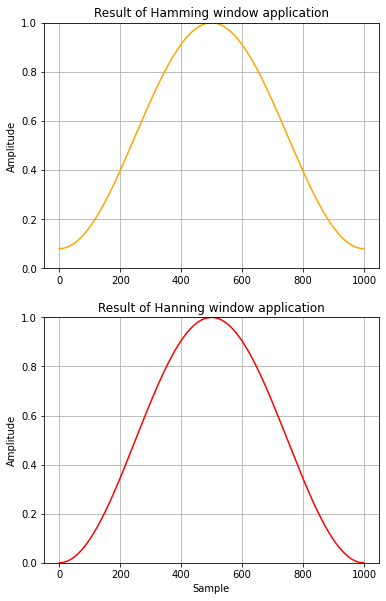

In [12]:
num_samp = 1000
sr = 4000
w = np.hamming(num_samp)
w_han = np.hanning(num_samp)

fig, axs = plt.subplots(2)
axs[0].plot(w,'orange')
axs[0].set_title('Result of Hamming window application')
axs[1].plot(w_han,'red')
axs[1].set_title('Result of Hanning window application')
plt.xlabel('Sample')
for ax in axs.flat:
    ax.set(ylabel='Amplitude')
    ax.grid(True, which='both')
    ax.set_ylim([0,1.0])
plt.subplots_adjust(top=2)

In [14]:
# transform window to the frequency domain
# we'll use Fast Fourier Transforms here - to be covered shortly!
w_fft = fft(w,2048)
whan_fft = fft(w_han,2048)

# compute the frequencies for the spectra
# freq array is the same for both windowing types
freq = fftfreq(2048,d=1/num_samp) 

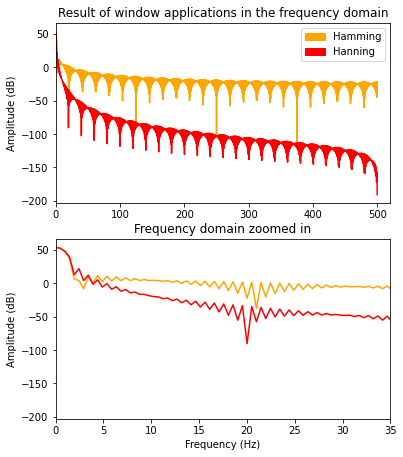

In [15]:
hamlab = matpat.Patch(color='orange', label='Hamming')
hanlab = matpat.Patch(color='red', label='Hanning')


#and plot the frequency response/frequency-domain data
fig, axs = plt.subplots(2)
axs[0].plot(freq,20*np.log10(abs(w_fft)),'orange') # this is how we convert to a dB scale!
axs[0].plot(freq,20*np.log10(abs(whan_fft)),'red')
axs[0].set_title('Result of window applications in the frequency domain')
axs[0].set_xlim(0,520)
axs[0].legend(handles=[hamlab,hanlab])
axs[1].plot(freq,20*np.log10(abs(w_fft)),'orange')
axs[1].plot(freq,20*np.log10(abs(whan_fft)),'red')
axs[1].set_xlim(0,35)
axs[1].set_title('Frequency domain zoomed in')
plt.xlabel('Frequency (Hz)')
for ax in axs.flat:
    ax.set(ylabel='Amplitude (dB)')
plt.subplots_adjust(top=1.5)

How do we apply the Hanning and Hamming window functions? And what happens to our time and frequency domain samples after Hanning or Hamming windowing?

Recall that window functions are (one-dimensional) arrays of N length where N is the total number of input samples. The expressions to create Hanning and Hamming window arrays are as follows:

    hann = 0.5 - 0.5*np.cos(2np.pi*n/N)
    
    ham = 0.54 - 0.46*np.cos(2np.pi*n/N)

where N is the number of input samples and n is the index of the input samples. Those are pretty straightforward formulas to use so we'll just implement them using handy scipy `signal` functions: 

In [16]:
# to return the time-domain array
def hamming_filter(data,sym): 
    w = signal.windows.hamming(len(data),sym)
    y = w*data # filter data along one dimension
    return y

def hanning_filter(data,sym):
    w = signal.windows.hann(len(data),sym)
    y = w*data
    return y

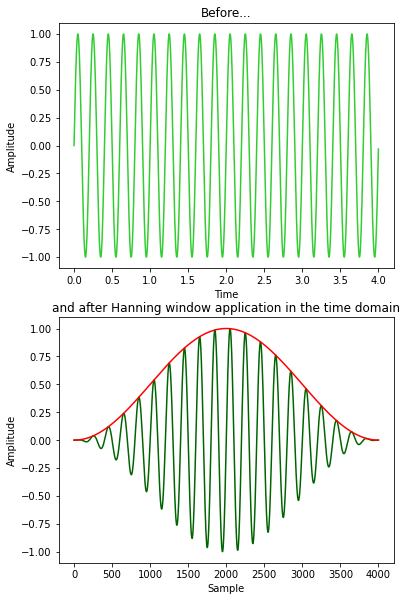

In [17]:
# plot the time domain data
sr = 1000
t_short = np.arange(0, 4, (1/sr)) 
a_short = np.sin(t_short*(2*np.pi)*5) 

fig, axs = plt.subplots(2)
axs[0].plot(t_short,a_short,'limegreen')
axs[0].set_title('Before...')
axs[0].set_xlabel('Time')
axs[1].plot(hanning_filter(a_short,False),'darkgreen')
axs[1].set_title('and after Hanning window application in the time domain')
axs[1].set_xlabel('Sample')
axs[1].plot(np.hanning(len(a_short)),'red')
for ax in axs.flat:
    ax.set(ylabel='Amplitude')
plt.subplots_adjust(top=2)

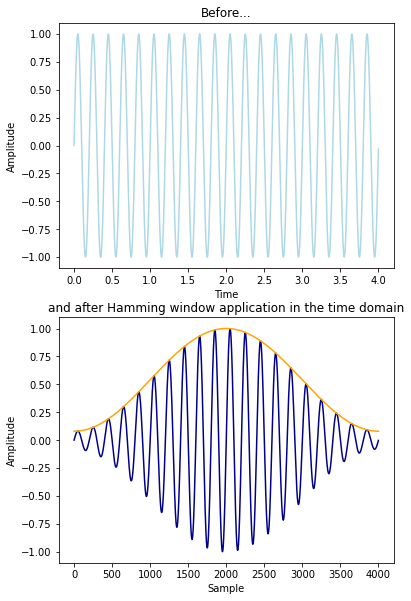

In [18]:
# plot the time domain data
fig, axs = plt.subplots(2)
axs[0].plot(t_short,a_short,'lightblue')
axs[0].set_title('Before...')
axs[0].set_xlabel('Time')
axs[1].plot(hamming_filter(a_short,False),'darkblue')
axs[1].set_title('and after Hamming window application in the time domain')
axs[1].set_xlabel('Sample')
axs[1].plot(np.hamming(len(a_short)),'orange')
for ax in axs.flat:
    ax.set(ylabel='Amplitude')
plt.subplots_adjust(top=2)

In [19]:
# Transform the windowed data to the frequency domain
han_in = fft(hanning_filter(a_short,True))
ham_in = fft(hamming_filter(a_short,True))

# compute the frequencies for the spectra
N = len(han_in) 
freq = fftfreq(4000,d=1/N) # a bit of zero padding

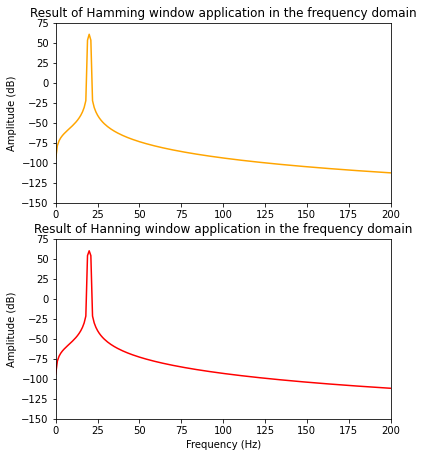

In [20]:
# and plot the frequency response/frequency-domain data
fig, axs = plt.subplots(2)
axs[0].plot(freq,20*np.log10(abs(ham_in)),'orange')
axs[0].set_title('Result of Hamming window application in the frequency domain')
axs[1].plot(freq,20*np.log10(abs(han_in)),'red')
axs[1].set_title('Result of Hanning window application in the frequency domain')
plt.xlabel('Frequency (kHz)')
for ax in axs.flat:
    ax.set(ylabel='Amplitude (dB)',xlim=(0,200),ylim=(-150,75))
plt.subplots_adjust(top=1.5)

Of course Librosa also has [windowing functions]((https://librosa.org/doc/main/generated/librosa.filters.get_window.html) but they're just wrappers of scipy's 

## 7. Fast Fourier Transform<a name="fft"></a>  

Up to this point, we have been working with rather sparse signals. For example, the complex `sinu` signal that we have been decomposing has just 240 samples, or a 60 Hz sampling rate (a 240-point DFT). 

But in speech analysis, we frequently work with sampling rates hundreds of times larger than that - at 16, 32, or 44.1 kHz, greatly enlarging the number of samples taken from the signal. Below, try manipulating the sampling rate of the `sinu` signal and then applying our `dft()` function. Sample high enough and you'll break the notebook! 

In [21]:
sr = 100
t = np.arange(0, 4, (1/sr)) 
sinu = np.sin(2*np.pi*5*t) + (np.sin(2*np.pi*10*t)+(3*np.pi/4))
out = dft(sinu)

The plot below displays the relationship between sampling rate and computation time for the DFT. 

In [22]:
# define array of sample rates
srs = np.arange(100,10000,100)

dur = []
for sr in srs:
    now = time.process_time()
    t = np.arange(0, 4, (1/sr)) 
    sig = np.sin(2*np.pi*5*t) + (np.sin(2*np.pi*10*t)+(3*np.pi/4))
    out = dft(sig)
    after = time.process_time() - now
    dur.append(after)

KeyboardInterrupt: 

In [ ]:
plt.plot(dur/1000,srs)
plt.title('Relationship between signal sampling rate and DFT computation time')
plt.xlabel('sampling rate')
plt.ylabel('Time (ms)')
plt.show()

Ideally, we could speed up the computational time to derive a DFT, and this is where an FFT, or **fast Fourier Transform**, comes in. For our purposes, it's not necessary to understand all of the underlying mathematical differences between the DFT and the FFT. It's sufficient to know that they DFT requires many times more multiplications than the FFT, slowing down its performance. The FFT computes much more efficiently, and is thus preferred.

Although there are innumerable built-in functions in various Python libraries to generate an FFT, and indeed we do not need to understand the differences between the FFT and the DFT, we will still define* it here so that the reader can see how it differs from the original DFT: 

    def FFT(x):

        N = len(x) # should be integral power of 2 
    
        if N == 1:
            return x
        else:
            X_even = FFT(x[::2]) # first we break the input into even 
            X_odd = FFT(x[1::2]) # and odd 
                                 # indexes to perform 2 separate DFTs
            t_factor = np.exp(-2j*np.pi*np.arange(N)/ N) # the twiddle factor
        
            X = np.concatenate([X_even+t_factor[:int(N/2)]*X_odd,
                                X_even+t_factor[int(N/2):]*X_odd])
            return X

* where x is the input time-domain signal sequence
* and X is the output frequency-domain signal sequence

And now we can employ the FFT going forward. 

One important caveat of the FFT is that it requires a specific number - an integral power of 2 - evenly-spaced samples in the input signal. That could still be a relatively small number of samples (2^4, or 16) or a very large number (2^12, or 4096). If we *don't* have an integral power of 2 samples, we can zero-pad the time domain signal; we will demonstrate this shortly. The important thing to remember is that the FFT, unlike the DFT, *demands* a power of 2 samples. 

*Thank you to [Python Programming and Numerical Methods](https://www.elsevier.com/books/python-programming-and-numerical-methods/kong/978-0-12-819549-9) for an illustration of this code!

## 8. Sampling and the FFT<a name="sampling"></a> 

We've previously established that we need to sample a signal at least twice as frequently as the highest frequency component that we wish to identify (Nyquist). Otherwise, we run the risk of aliasing and generating frequencies in the spectrum that were not present in the input signal. But what is the relationship between sampling rate and the FFT? Well, besides identifying that highest frequency signal component, we may also wish to identify the *granularity* or resolution of the signal in the frequency domain. A higher resolution will allow us to estimate the amplitude of the signal at increasingly finer-grained frequencies; for example, we may wish to know the signal amplitude at every 25, 10, or 5Hz. 

The length of the sampled signal and frequency resolution are inversely related: if we sample over a longer signal, we achieve a more fine-grained resolution in the frequency domain, meaning less space between measurement points in the spectrum. Below are two plots capturing this relationship between length of signal sampled in the time domain/number of samples and resolution in the frequency domain. 

In [23]:
samples = 2**np.arange(11)[4:] # simulate different sample numbers, but always a power of 2
sr = 8000 # consistent sr
res_list = []
secs_list = []
for s in samples:
    secs = 1000*(s / 8000) # duration of signal (window length) 
    res = 8000 / s
    secs_list.append(secs)
    res_list.append(res)

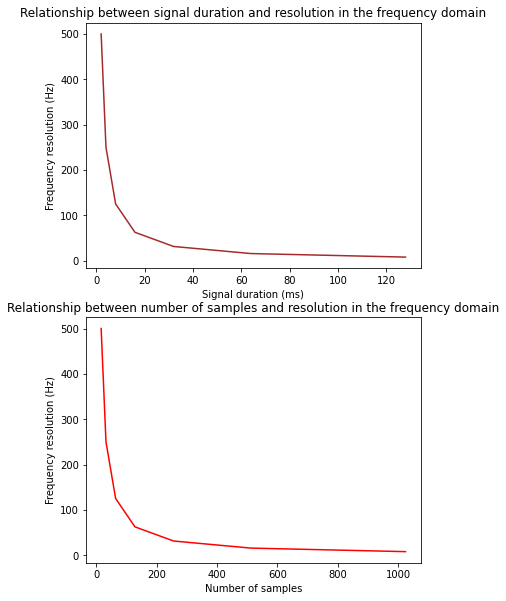

In [24]:
fig, axs = plt.subplots(2)
axs[0].plot(secs_list,res_list,'brown')
axs[0].set_title('Relationship between signal duration and resolution in the frequency domain')
axs[0].set_xlabel('Signal duration (ms)')
axs[1].plot(samples,res_list,'red')
axs[1].set_title('Relationship between number of samples and resolution in the frequency domain')
axs[1].set_xlabel('Number of samples')
for ax in axs.flat:
    ax.set(ylabel='Frequency resolution (Hz)')
plt.subplots_adjust(top=2)

At an 8kHz sampling rate, 256 samples will give us a 31.25Hz resolution in the frequency domain which is pretty good!

So we know that we can improve frequency resolution by sampling over a longer window in the time domain; the spectral details will be better-defined. But what about the frequencies *between* the output measures from the FFT? Well, we don't have amplitude measurements for them - which is why it's important to consider your desired frequency resolution when you choose your window size during FFT computation. However, when the frequency resolution is small enough, we can estimate the amplitude measures between frequency points, resulting in an estimated continuous spectral envelope, which we will explore shortly. 

If frequency resolution is improved by using longer samples, could we just sample over a really, really long window to achieve our desired frequency resolution?

Unfortunately not. For one thing, speech - even relatively slow child speech - can unfold quickly, between 3-7 syllables/second. Let's listen to the baby vocalization that we've played in earlier tutorials to illustrate why simply increasing the window length won't work to increase frequency resolution. 

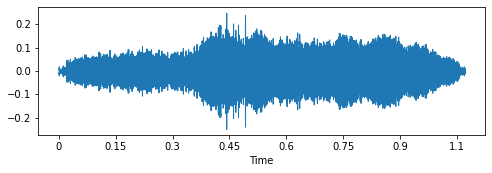

In [25]:
sound_file, baby_sr = lb.load(path+'/files/Cychosz_105_740_1138.76_1139.83.wav',sr=16000)

plt.figure(figsize=(8, 8))
plt.subplot(3, 1, 1)
lb.display.waveshow(sound_file, sr=baby_sr)
ipd.Audio(data=sound_file,rate=baby_sr)

Let's say that we are interested in the spectral structure of the initial round vowel. In the waveform above, we can see that its duration is, approximately, 300ms. We'll take the first third of that. So we can take a window size of 100ms, apply an FFT, and view the resulting spectrum:  

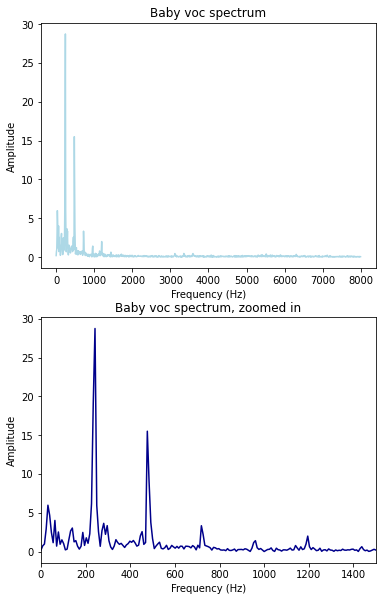

In [26]:
# 100ms from a 1070ms signal sampled at 16kHz is appx. 1712 samples (.1*len(sound_file))
# we round up to an integer of 2, however, so we'll take 2048 samples

baby_fft = fft(sound_file[:2048])

# get frequency structure
N = len(sound_file[:2048])
nyq = N//2
baby_freq = ((np.arange(N)*baby_sr)/N)
# or another built-in option
#baby_freq = fftfreq(len(baby_fft))


fig, axs = plt.subplots(2)
axs[0].plot(baby_freq[:nyq], abs(baby_fft)[:nyq],'lightblue') 
axs[0].set_title('Baby voc spectrum')
axs[1].plot(baby_freq[:nyq], abs(baby_fft)[:nyq],'darkblue') 
axs[1].set_title('Baby voc spectrum, zoomed in')
axs[1].set_xlim(0,1500)
for ax in axs.flat:
    ax.set(ylabel='Amplitude',xlabel="Frequency (Hz)")
plt.subplots_adjust(top=2)

The frequency resolution is pretty good (7.81Hz steps, based on a sampling rate of 16k divided by 2048 samples), but it's maybe not as detailed as we would like. We could return to our original sound file and simply look over a larger window. But in case it's not immediately apparent why that's a problem, we can first listen to the sound file again, and then visualize a spectrum taken from that larger window, let's say quadruple the size of the original window so 400ms. 

400ms from a 1070ms signal sampled at 6kHz is approximately 6848 samples, so we'll round up to the integer of 2 (8192 samples) using **zero padding**. Zero padding allows us to artificially increase the frequency resolution by  adding more samples to the input domain in the form of 0s appended to the input array (this concept that was introduced in the synthesis tutorial):

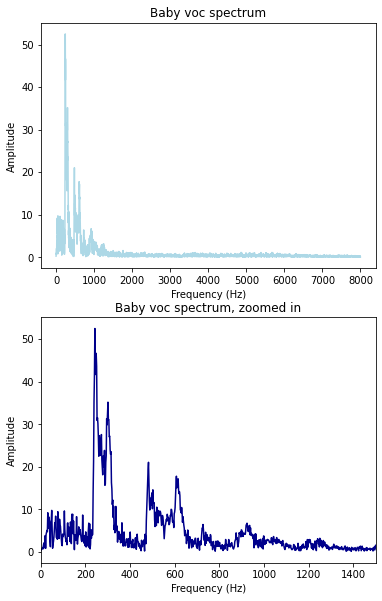

In [27]:
long_win = lb.util.fix_length(sound_file[:6848], size=8192) # pad with zeros

baby_fft = fft(long_win) # get the fft

# get frequency structure
N = len(long_win)
nyq = N//2
baby_freq = ((np.arange(N)*baby_sr)/N)


fig, axs = plt.subplots(2)
axs[0].plot(baby_freq[:nyq], abs(baby_fft)[:nyq],'lightblue')
axs[0].set_title('Baby voc spectrum')
axs[1].plot(baby_freq[:nyq], abs(baby_fft)[:nyq],'darkblue')
axs[1].set_title('Baby voc spectrum, zoomed in')
axs[1].set_xlim(0,1500)
for ax in axs.flat:
    ax.set(ylabel='Amplitude',xlabel="Frequency (Hz)")
plt.subplots_adjust(top=2)

Well, the resolution of the signal might have improved - there's certainly more detail in the spectral envelope -  but our longer window has also resulted in **spectral smearing** where we've averaged the signal over too long of a duration. Our frequency resolution has come at the expense of our temporal resolution. In this case, we've captured the spectral structure of not simply the initial `[u]`: 

In [ ]:
ipd.Audio(data=sound_file[:2048],rate=baby_sr)

but the transition (diphthong) into the adjacent, higher amplitude vowel: 

In [ ]:
ipd.Audio(data=sound_file[:6848],rate=baby_sr)

which, among other things, has lots of low-frequency noise from the child's rustling shirt (remember that this baby's speech was recorded using a small, wearable audio recorder). This low-frequency noise is polluting our spectrum and making it hard to derive the spectral content of the vowel.

So we can't simply take an infinitely long window - even with zero padding - to achieve better frequency resolution. Speech unfolds too quickly and temporal and frequency resolution are inversely related. Instead we need to carefully consider our recordings - the speaker, the setting, the conversational pace - to determine window length. 

### Real fast Fourier transforms 

Up until this point, we have called the traditional `fft()` function under the assumption that our input array consists of complex numbers (with real and imaginary components). 

But speech is an example of a real-valued time domain input array. So we can save time and computational resources by not calculating the negative component of the frequency domain signal:

In [ ]:
fig, axs = plt.subplots(2)
axs[0].plot(fftfreq(N, 1 / sr),abs(fft(sinu,n=256)),'lightblue')
axs[0].set_title('output of a fast Fourier transform')
axs[1].plot(rfftfreq(N, 1 / sr),abs(rfft(sinu,n=256)),'darkblue')
axs[1].set_title('output of a real-valued fast Fourier transform')
plt.xlabel('Frequency')
plt.subplots_adjust(top=2)
fig.tight_layout()

for ax in axs.flat:
    ax.set(ylabel='Amplitude',ylim=(0,200))

Why does `rfft()` only compute the positive frequencies? Because when given real-valued input, the negative frequencies in the DFT output are just complex conjugates (the opposite polarity of the imaginary part of a number) of the positive frequencies in the DFT output: this is why they appear to mirror the positive frequencies in the output spectrum. The negative frequences are thus redundant, unnecessary, and thus not computed under `rfft()`. 

### Discrete cosine transforms and compression 

In speech science, we are rarely interested in compressing our audio recordings to lossy formats such as .mp3. However, it is worth exploring a common method behind audio compression, the **discrete cosine transform**, because it is a special case of Fourier transforms. The difference between discrete Fourier and cosine transforms is apparent in the name: the former relies on sums of sine and cosine functions but the latter only relies on cosine functions. 

Fourier transforms assume an infinite, periodic function, as we have seen visualized many times throughout these tutorials. Cosine functions, however, have different **boundary conditions**, instead osillating with an [even symmetry](https://oer.physics.manchester.ac.uk/PDEs/Notes/jsmath/Notesse15.html) along the x-axis. Discontinuities in a function affect how easy it is to transform the function to the frequency domain - more discontinuities require more detailed observations in the form of more sinusoids. So if the goal is computational ease, a discrete cosine transform, which assumes even symmetry, is ideal because measurements are frequently repeated across the even and odd (left - right) boundary conditions and fewer observations are required to transform the function to the frequency domain. This predictability in the even symmetry function is why discrete cosine transforms make it easier to compress signals and generate formats such as .mp3. 

## Glossary 

*under construction!*

**anti-aliasing filter** = 

**frequency bin** = 

**fundamental frequency** = 

**harmonic** = 

**power spectrum** = 

**magnitude spectrum** = 

**N-point discrete Fourier transform** = the number of input values over which we perform the DFT

**sidelobe** = 

**time-frequency localization trade-off** = the trade-off between temporal and frequency resolution; prioritizing temporal means you can distinguish between amplitude measures that are taken in close chronological succession; prioritizing frequency means you can distinguish between tones at similar frequencies

**windowing** =